In [182]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature
from skimage.morphology import binary_erosion



In [162]:
def getBorderColor(img):
    
    border = np.asarray(img[0,:])
    border = np.concatenate((border, np.asarray(img[-1, :])))
    border = np.concatenate((border, np.asarray(img[:, 0])))
    border = np.concatenate((border, np.asarray(img[:, -1])))
    #print(border)
    #print(border)
    return np.bincount(border).argmax()

def pre_processing(img):
    #img_blurred = cv2.medianBlur(img,5)
    #img_binarized = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, img_binarized = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    if(getBorderColor(img_binarized) != 0):
        img_binarized = cv2.bitwise_not(img_binarized) 
    #img_binarized = adaptiveThresh(img, t=15, div=8)
    return img_binarized

In [163]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(pre_processing(img))
    return images

In [164]:
#follow the ration 60% 20% 20%
TRAINING_SIZE = 114
VALIDATION_SIZE = 38
TEST_SIZE = 38

TRAINING_OFFSET = TRAINING_SIZE
VALIDATION_OFFSET = TRAINING_OFFSET + VALIDATION_SIZE

training_set = []
validation_set = []
test_set = []

for i in range (1, 10):
    class_i_images = load_images_from_folder("ACdata_base/" + str(i))
    training_set.append(class_i_images[0:TRAINING_OFFSET])
    validation_set.append(class_i_images[TRAINING_OFFSET: VALIDATION_OFFSET])
    test_set.append(class_i_images[VALIDATION_OFFSET:])

In [165]:

def showImage(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    #print(getBorderColor(img))
    #w, h = img.shape[:2]
    #print(cv2.countNonZero(img)/(w*h) * 100)


#arr = np.array([[1,2,3], [4,5,6], [7,8,9]])
#getBorderColor(arr)

In [166]:

# for i in range(len(test_set)):
#     for j in range(len(test_set[i])):
#         showImage(test_set[i][j])

In [167]:
def getFeaturesHOG(img):
   img = cv2.resize(img, (256, 128))
   cell_size = (32, 32)  # h x w in pixels
   block_size = (2, 2)  # h x w in cells
   nbins = 9  # number of orientation bins
   # winSize is the size of the image cropped to an multiple of the cell size
   hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

   hog_feats = hog.compute(img)
   return hog_feats.flatten() 

In [168]:
def get_X_Y_Train():
   X_Train = []
   Y_Train = []
   for i in range(len(training_set)):
      for j in range(len(training_set[i])):
        X_Train.append(getFeaturesHOG(training_set[i][j]))
        Y_Train.append(i+1)
   return (X_Train, Y_Train)

In [169]:
img = training_set[0][0]
print(len(getFeaturesHOG(img)))

756


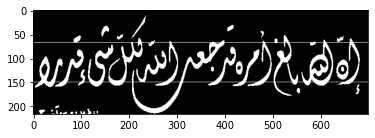

In [170]:
# pre processing of the image (baseline estimation)
def enhanced_pre_processing(img):
    horz_proj = np.sum(img, 1)
    lb = np.argmax(horz_proj)
    avg_row_density = np.average(horz_proj)
    for inx, row_proj in enumerate(horz_proj):
        if row_proj >= avg_row_density:
            lu = inx
            break
    showImage(img)
    return lb,lu


image = load_images_from_folder("ACdata_base/1")[0]
lb, lu = enhanced_pre_processing(image)


In [171]:
# feature extraction parameters
# number of cells according to paper guidlines
N = 20
# width of kernal according to paper guidlines
WIDTH = 8 
HEIGHT = int(image.shape[0] / N)
# a paramter of my selection
STRID = 4


In [172]:
# feature f1 (density of foreground (black) pixels.)

img_height = image.shape[0]
img_width = image.shape[1]
f1 = []
# Crop out the window and calculate f1 for each cell
for r in range(img_width - 1, WIDTH - 1, -STRID):
    foreground = []
    for c in range(0, img_height, HEIGHT):
        window = image[c:c+HEIGHT-1, r-WIDTH:r]
        foreground.append(np.sum(window == 255) / (WIDTH * HEIGHT))
    f1.append(np.sum(foreground))


In [173]:
# number of transitions black/white between two consecutive cells.
f2 = []
for r in range(img_width - 1, WIDTH - 1, -STRID):
    cells = []
    #get the cells in each window
    for c in range(0, img_height, HEIGHT):
        cells.append(image[c:c+HEIGHT-1, r-WIDTH:r])
    summtion = 0
    for i in range(2,N):
        bi = int(np.sum(cells[i] == 255) == 0)
        b_i = int(np.sum(cells[i - 1] == 255) == 0)
        summtion += np.abs(bi - b_i )
    f2.append(summtion)
        


In [174]:
def get_center_of_mass(window):
    # calculate moments of binary image
    M = cv2.moments(window)
    # calculate x,y coordinate of center
    cX = int(M["m10"] / (M["m00"] + 1e-5))
    cY = int(M["m01"] / (M["m00"] + 1e-5))
    return cX,cY


In [175]:
# f3 difference’s position of gravity centers of foreground pixels in two consecutive frame (current and previous)
f3 = []
centers = []
for r in range(img_width - 1, WIDTH - 1, -STRID):
    centers.append(get_center_of_mass(image[:, r-WIDTH:r]))
f3.append(np.sqrt(np.power(centers[0][0], 2) + np.power(centers[0][1], 2)))
for i in range(1,len(centers)):
    f3.append(np.sqrt(np.power(centers[i][0] - centers[i - 1][0],
                       2) + np.power(centers[i][1] - centers[i - 1][1], 2)))

In [176]:
# f4 normalized vertical position of the center of gravity of the foreground pixels in the whole frame with respect tothe lower baseline.
f4 = []
centers = []
for r in range(img_width - 1, WIDTH - 1, -STRID):
    centers.append(get_center_of_mass(image[:, r-WIDTH:r]))
for i in range(0, len(centers)):
    f4.append(np.sqrt(np.power(centers[i][1] - lb, 2) / img_height))


In [177]:
#f5,f6 represent the density of foreground pixels over and under the lower baselines.
f5 = []
f6 = []
print(lb)
for r in range(img_width - 1, WIDTH - 1, -STRID):
    f5.append(np.sum(image[0:lb-1, r-WIDTH:r] == 255) / (lb * WIDTH))
    f6.append(np.sum(image[lb:, r-WIDTH:r] == 255) / ((img_height - lb) * WIDTH))

149


In [178]:
k = -1
index = 0
for c in range(0, img_height, HEIGHT):
    if c >= lb:
        k = c
        break
    index += 1

f7 = []
for r in range(img_width - 1, WIDTH - 1, -STRID):
    cells = []
    #get the cells in each window
    for c in range(0, k, HEIGHT):
        cells.append(image[c:c+HEIGHT-1, r-WIDTH:r])
    summtion = 0
    for i in range(2, len(cells)):
        bi = int(np.sum(cells[i] == 255) == 0)
        b_i = int(np.sum(cells[i - 1] == 255) == 0)
        summtion += np.abs(bi - b_i)
    f7.append(summtion)

In [179]:
# zone to which the gravity center of black pixels belongs (lower zone f8 = 3, middle zone f8 = 2, upper zone f8 = 1)
f8 = []
for r in range(img_width - 1, WIDTH - 1, -STRID):
    center_y = get_center_of_mass(image[:, r-WIDTH:r])[1]
    if center_y > lb:
        f8.append(3)
    elif center_y < lb and center_y > lu:
        f8.append(2)
    else:
        f8.append(1)

In [191]:
# Cleft-up: the number of background pixels that have neighbor black pixels in the two directions (left and up)
#The same applies to f9, . . ., f14 in six directions left-up, up-right, right-down, down-left, vertical and horizontal.f15, . . ., f20
f9 = []
f10 = []
f11 = []
f12 = []
f13 = []
f14 = []
for r in range(img_width - 1, WIDTH - 1, -STRID):
    window = image[:, r-WIDTH:r]
    k1 = np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 0]
    ])
    k2 = np.array([
        [0, 0, 1],
        [0, 1, 1],
        [1, 1, 0]
    ])
    
    f9.append(np.sum(binary_erosion(255 - window, k2) * binary_erosion(window, k1))/ img_height)
    
    k1 = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0]
    ])
    k2 = np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1]
    ])    
    f10.append(np.sum(binary_erosion(255 - window, k2) * binary_erosion(window, k1))/ img_height)
    
    
    k1 = np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ])
    k2 = np.array([
        [0, 1, 1],
        [1, 1, 0],
        [1, 0, 0]
    ])    
    f11.append(np.sum(binary_erosion(255 - window, k2) * binary_erosion(window, k1))/ img_height)
    
    k1 = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0]
    ])
    k2 = np.array([
        [1, 1, 0],
        [0, 1, 1],
        [0, 0, 1]
    ])    
    f12.append(np.sum(binary_erosion(255 - window, k2) *
                      binary_erosion(window, k1)) / img_height)
    
    k1 = np.array([
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])
    k2 = np.array([
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]
    ])    
    f13.append(np.sum(binary_erosion(255 - window, k2) *
                      binary_erosion(window, k1)) / img_height)
    
    k1 = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]
    ])
    k2 = np.array([
        [0, 0, 0],
        [1, 1, 1],
        [0, 0, 0]
    ])    
    f14.append(np.sum(binary_erosion(255 - window, k2) * binary_erosion(window, k1)) / img_height)


In [193]:
# Cleft-up: the number of background pixels that have neighbor black pixels in the two directions (left and up)
#The same applies to f9, . . ., f14 in six directions left-up, up-right, right-down, down-left, vertical and horizontal.f15, . . ., f20
f15 = []
f16 = []
f17 = []
f18 = []
f19 = []
f20 = []
for r in range(img_width - 1, WIDTH - 1, -STRID):
    window = image[lu:lb, r-WIDTH:r]
    k1 = np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 0]
    ])
    k2 = np.array([
        [0, 0, 1],
        [0, 1, 1],
        [1, 1, 0]
    ])
    
    f15.append(np.sum(binary_erosion(255 - window, k2) * binary_erosion(window, k1))/ np.abs(lb-lu))
    
    k1 = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0]
    ])
    k2 = np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1]
    ])    
    f16.append(np.sum(binary_erosion(255 - window, k2) *
                      binary_erosion(window, k1)) / np.abs(lb-lu))
    
    
    k1 = np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ])
    k2 = np.array([
        [0, 1, 1],
        [1, 1, 0],
        [1, 0, 0]
    ])    
    f17.append(np.sum(binary_erosion(255 - window, k2) *
                      binary_erosion(window, k1)) / np.abs(lb-lu))
    
    k1 = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0]
    ])
    k2 = np.array([
        [1, 1, 0],
        [0, 1, 1],
        [0, 0, 1]
    ])    
    f18.append(np.sum(binary_erosion(255 - window, k2) *
                      binary_erosion(window, k1)) / np.abs(lb-lu))
    
    k1 = np.array([
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])
    k2 = np.array([
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]
    ])    
    f19.append(np.sum(binary_erosion(255 - window, k2) *
                      binary_erosion(window, k1)) / np.abs(lb-lu))
    
    k1 = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]
    ])
    k2 = np.array([
        [0, 0, 0],
        [1, 1, 1],
        [0, 0, 0]
    ])    
    f20.append(np.sum(binary_erosion(255 - window, k2) *
                      binary_erosion(window, k1)) / np.abs(lb-lu))


In [195]:
f21 = []
f22 = []
f23 = []
f24 = []
f25 = []
f26 = []
f27 = []
f28 = []

for r in range(img_width - 1, WIDTH - 1, -STRID):
    window = image[lu:lb, r-WIDTH:r]
    f21.append(np.sum(window[0, :]) / img_height)
    f22.append(np.sum(window[1, :]) / img_height)
    f23.append(np.sum(window[2, :]) / img_height)
    f24.append(np.sum(window[3, :]) / img_height)
    f25.append(np.sum(window[4, :]) / img_height)
    f26.append(np.sum(window[5, :]) / img_height)
    f27.append(np.sum(window[6, :]) / img_height)
    f28.append(np.sum(window[7, :]) / img_height)


